<a href="https://colab.research.google.com/github/souhirbenamor/EPF/blob/main/EEMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Time Series Analysis using EMD and Dilated Convolutional Neural Networks¶**
https://github.com/3catz/deeplearning_timeseries/blob/master/Air_Quality_Time_Series_Series_Forecasting_with_EEMD_and_Fully_Convolutional_Neural_Networks.ipynb

In [3]:
!pip install EMD-signal
!pip install auto_ml
!pip install pyhht
!pip install six
#!pip install -U scikit-learn scipy matplotlib

#import six
#import sys
#sys.modules['sklearn.externals.six'] = six
#from auto_ml import Predictor
#from auto_ml.utils import get_boston_dataset
#from auto_ml.utils_models import load_ml_model

from PyEMD import EEMD 
eemd = EEMD(max_imfs=8)
#pip install PeakUtils
from sklearn.preprocessing import MinMaxScaler, RobustScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score

import matplotlib.pyplot as plt
import os 
from scipy.integrate import odeint
#keras
from keras.models import *
from keras.layers import * 
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K


In [4]:
def series_to_supervised(data, n_in, n_out, dropnan=True):

	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [5]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')

In [6]:
data= pd.read_csv("/content/BE_price.csv")

In [7]:
#import numpy as np  
#data = np.fromfile("BE_price.csv", sep = "\n")
#data.shape

In [8]:
import numpy as np
data = np.genfromtxt("BE_price.csv", delimiter = ","); data = np.asarray(data); data.shape

(52416,)

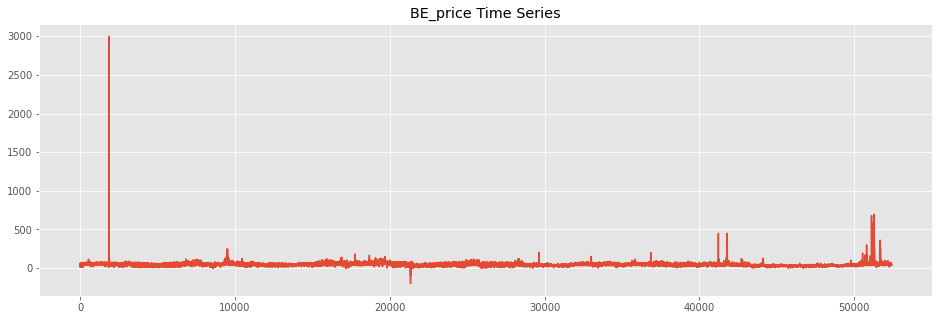

In [9]:
plt.figure(figsize=(16,5))
plt.plot(data)
plt.title("BE_price Time Series")
plt.show()

In [10]:
#Scale the Data
scaler = MinMaxScaler(feature_range = (-1,1)) 
scaled_data = scaler.fit_transform(data.reshape(-1,1))
scaled_data.shape
scaled_data = np.squeeze(scaled_data)
scaled_data.shape

(52416,)

In [11]:
scaled_data = np.transpose(scaled_data)

In [12]:
# before you do the EMD, cut out the out of sample part so that the EMDs are not constructed with those future values and information contained within them

in_sample = scaled_data[:-17472]; out_sample = scaled_data[-17472:]
print(in_sample.shape)
print(in_sample)

(34944,)
[-0.85461707 -0.86148796 -0.86513911 ... -0.84842763 -0.84868396
 -0.84938418]


In [13]:
in_sample = in_sample.reshape(-1,1)
out_sample = out_sample.reshape(-1,1)
print(in_sample)


[[-0.85461707]
 [-0.86148796]
 [-0.86513911]
 ...
 [-0.84842763]
 [-0.84868396]
 [-0.84938418]]


In [14]:
#eemd for in-sample
eemd = EEMD()
eemd.extrema_detection = "simple"
t = np.linspace(0, in_sample.shape[0], in_sample.shape[0])
t = t.reshape(-1,1)
print(t.shape, in_sample.shape)
t = np.squeeze(t)
in_sample = np.squeeze(in_sample)




(34944, 1) (34944, 1)


In [15]:
#eemd for in-sample
imfs_in = eemd(in_sample, t, 8)

print(imfs_in.shape)

(9, 34944)


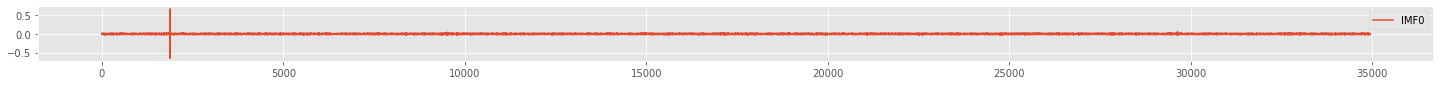

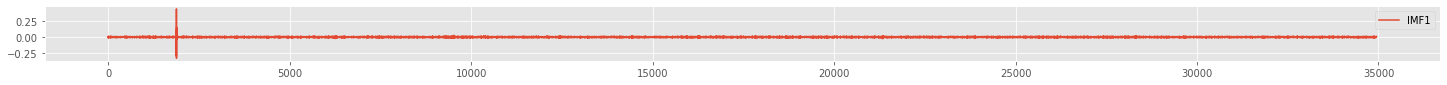

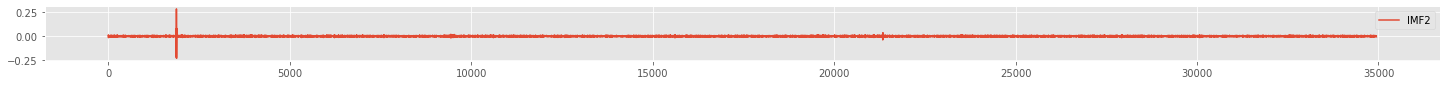

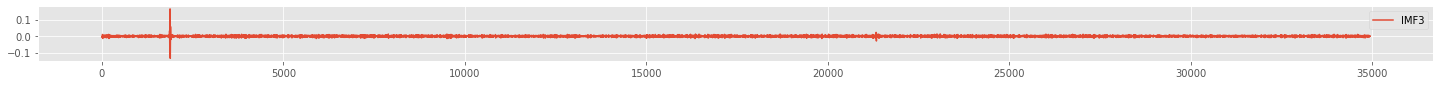

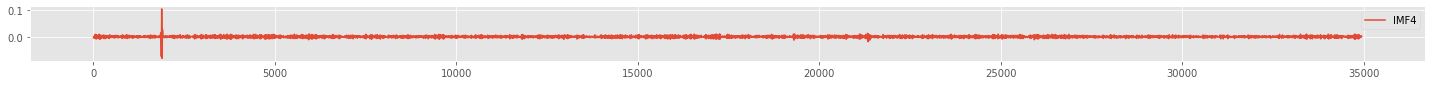

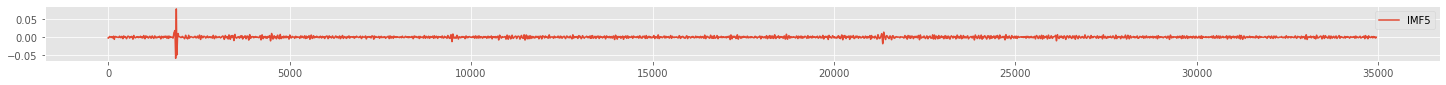

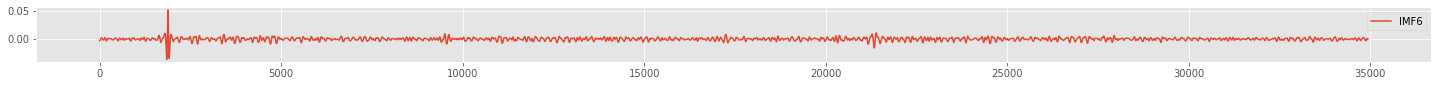

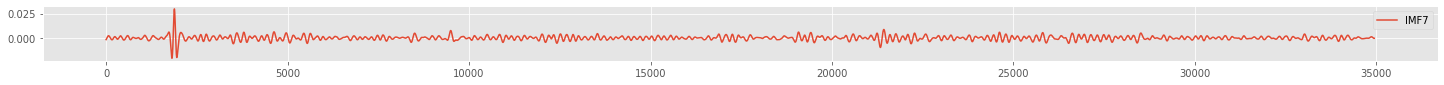

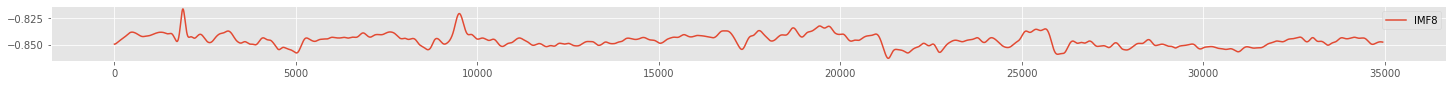

In [16]:
for i in range(len(imfs_in)):
  fig, ax = plt.subplots(figsize=(25,1))
  fig = plt.plot(imfs_in[i], label = "IMF{}".format(i))
  plt.legend()
  plt.show()

In [17]:
#eemd for out-sample
eemd = EEMD()
eemd.extrema_detection = "simple"
t_out = np.linspace(0, out_sample.shape[0], out_sample.shape[0])
t_out = t_out.reshape(-1,1)
print(t_out.shape, out_sample.shape)
t_out = np.squeeze(t_out)
out_sample = np.squeeze(out_sample)


(17472, 1) (17472, 1)


In [20]:
#eemd for in-sample
imfs_out = eemd(out_sample, t_out, 8)

print(imfs_out.shape)

(9, 17472)


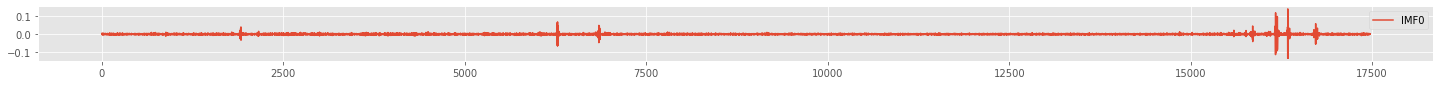

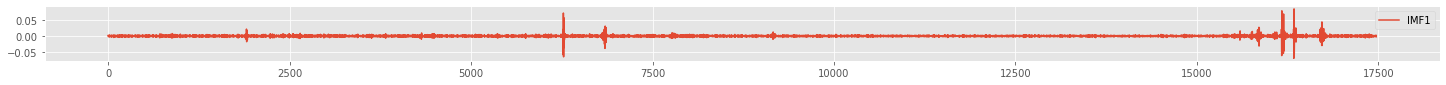

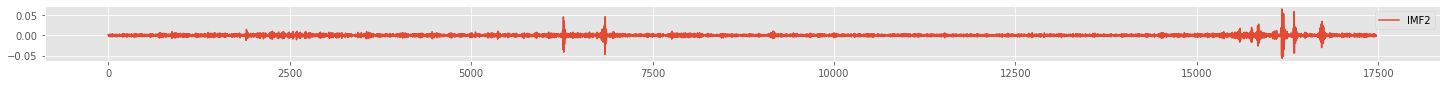

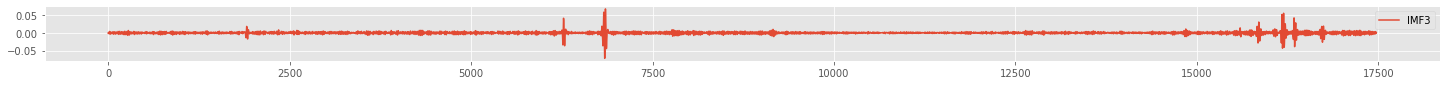

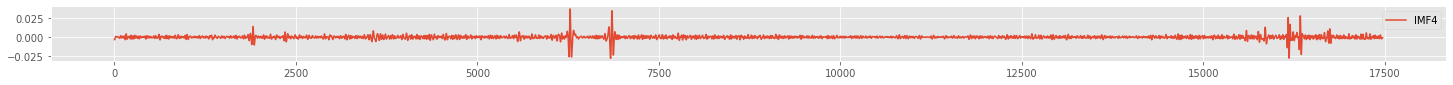

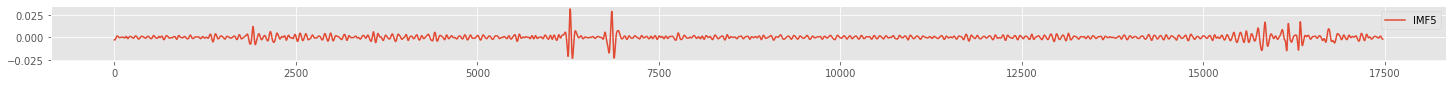

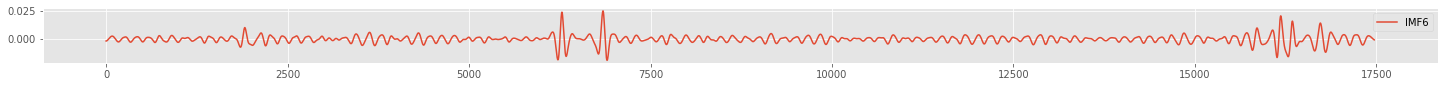

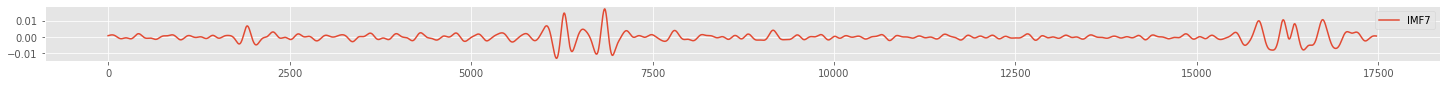

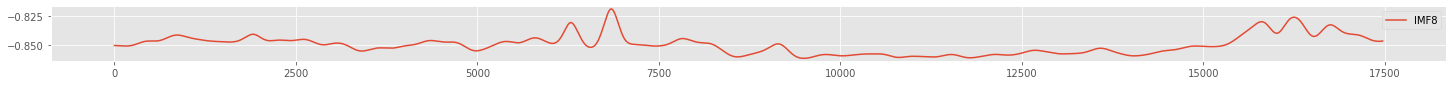

In [21]:
for i in range(len(imfs_out)):
  fig, ax = plt.subplots(figsize=(25,1))
  fig = plt.plot(imfs_out[i], label = "IMF{}".format(i))
  plt.legend()
  plt.show()

In [28]:
# Save in_sample and out_sample decomposition data
from pandas import DataFrame
import pandas as pd
import csv
Eemd_in_sample=pd.DataFrame(imfs_in).T
Eemd_out_sample=pd.DataFrame(imfs_out).T
# Save as csv
Eemd_in_sample.to_csv("Eemd_in_sample.csv", header=True, quoting=csv.QUOTE_NONE, escapechar=' ')
Eemd_out_sample.to_csv("Eemd_out_sample.csv", header=True, quoting=csv.QUOTE_NONE, escapechar=' ')

# Save as excel
Eemd_in_sample.to_excel("Eemd_in_sample.xlsx", header=True)
Eemd_out_sample.to_excel("Eemd_out_sample.xlsx", header=True)
print(Eemd_in_sample)
print(Eemd_out_sample)


              0         1         2  ...         6         7         8
0      0.014257  0.000471  0.008000  ... -0.002949 -0.001700 -0.849635
1     -0.006771 -0.009285  0.006897  ... -0.002957 -0.001645 -0.849634
2      0.015299 -0.013477  0.004351  ... -0.002944 -0.001588 -0.849632
3     -0.004020 -0.001738  0.000255  ... -0.002909 -0.001528 -0.849630
4      0.002776  0.013855 -0.005121  ... -0.002855 -0.001467 -0.849627
...         ...       ...       ...  ...       ...       ...       ...
34939 -0.002403  0.001097  0.002427  ...  0.000183 -0.000441 -0.847657
34940 -0.008736  0.006966  0.002349  ...  0.000126 -0.000437 -0.847664
34941  0.011995  0.007910 -0.000889  ...  0.000074 -0.000431 -0.847671
34942 -0.014578  0.011582 -0.004907  ...  0.000026 -0.000423 -0.847677
34943 -0.005918  0.011129 -0.005832  ... -0.000015 -0.000414 -0.847684

[34944 rows x 9 columns]
              0         1         2  ...         6         7         8
0      0.003486  0.001430  0.001581  ... -0.001663 

In [29]:

# Merge in_ and out_samples in one file and save the full decomposed sample  

frames = [Eemd_in_sample, Eemd_out_sample]

BE_price_Eemd = pd.concat(frames)
BE_price_Eemd=BE_price_Eemd.reset_index()
del BE_price_Eemd[BE_price_Eemd.columns[0]]
BE_price_Eemd.to_csv("BE_price_Eemd.csv", header=True, quoting=csv.QUOTE_NONE, escapechar=' ')
BE_price_Eemd.to_excel("BE_price_Eemd.xlsx", header=True)
print(BE_price_Eemd)

              0         1         2  ...         6         7         8
0      0.014257  0.000471  0.008000  ... -0.002949 -0.001700 -0.849635
1     -0.006771 -0.009285  0.006897  ... -0.002957 -0.001645 -0.849634
2      0.015299 -0.013477  0.004351  ... -0.002944 -0.001588 -0.849632
3     -0.004020 -0.001738  0.000255  ... -0.002909 -0.001528 -0.849630
4      0.002776  0.013855 -0.005121  ... -0.002855 -0.001467 -0.849627
...         ...       ...       ...  ...       ...       ...       ...
52411 -0.000966  0.001310  0.000342  ... -0.000510  0.000685 -0.846207
52412  0.001773 -0.000672 -0.000732  ... -0.000538  0.000678 -0.846198
52413 -0.000626 -0.002189 -0.001849  ... -0.000563  0.000672 -0.846188
52414 -0.000642 -0.002955 -0.002372  ... -0.000586  0.000665 -0.846179
52415  0.001791 -0.002054 -0.001613  ... -0.000605  0.000658 -0.846169

[52416 rows x 9 columns]
